# Feature Engineering
Do feature engineering 
- <a href='#1'>1. get_top_clicking_feat_for_each_group </a> 
- <a href='#2'>2. generate user-related feats </a> 
- <a href='#3'>3. feature selection </a> 

In [8]:
# ! pip install gensim -i http://mirrors.aliyun.com/pypi/simple/ --trusted-host mirrors.aliyun.com
%load_ext autoreload
%autoreload 2
import sys
import os 
import gc
import functools
from collections import Counter

import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import multiprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec, KeyedVectors
from tqdm import tqdm
import seaborn as sns

sys.path.append('../')
import conf
from utils import (
    check_columns, 
    check_nan_value,
    correct_column_type_by_value_range,
    LogManager,
    timer
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# global settings
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns',1000)
pd.set_option('display.width',100)
sns.set(rc={'figure.figsize':(20,10)})

In [10]:
# global variables
DEFAULT_MISSING_VALUE = 0
FONT = fm.FontProperties(fname = os.path.join(conf.LIB_DIR,'simsun.ttc'))
LogManager.created_filename = os.path.join(conf.LOG_DIR, 'feature_engineering.log')
logger = LogManager.get_logger(__name__)

In [11]:
# functions
def __dummy():
    pass

In [12]:
# load dataset
raw_train_df = pd.read_feather(os.path.join(conf.DATA_DIR, 'raw_train_df.feather'))
raw_test_df = pd.read_feather(os.path.join(conf.DATA_DIR, 'raw_test_df.feather'))

In [14]:
assert len(raw_train_df.user_id.unique()) == 3000000

In [15]:
assert len(raw_test_df.user_id.unique()) == 1000000

### <a id='1'> 1. get top clicking feat for each group</a>

In [9]:
def get_top_clicking_feat_for_each_group(
    train_df, 
    label, 
    feat, 
    group, 
    num_top
):
    mask = train_df[label] == group
    tmp_df = train_df[mask]
    tmp_df = tmp_df[
        [
        'time',
        'user_id',
        feat,
        'age',
        'gender',
        'y']
    ]
    tmp_df.drop_duplicates(subset=['user_id',feat],inplace=True)
    ret = tmp_df[feat].value_counts().iloc[:num_top]
    return ret

def get_top_unique_clicking_list(
        train_df, 
        label, 
        feat,  
        num_top,
        threshold
):
    record_dict = dict()
    for group in tqdm(train_df[label].unique()):
        ret = get_top_clicking_feat_for_each_group(train_df, label, feat, group, num_top)
        for v in ret.index.values:
            try:
                record_dict[v]+=1
            except KeyError:
                record_dict[v] =1
    top_unique_clicking_list = list(filter(lambda x : record_dict[x]<threshold, record_dict))
    return set(top_unique_clicking_list), record_dict

In [10]:
top_unique_advertiser_id_clicking_list, advertiser_id_record_dict = get_top_unique_clicking_list(
    train_df=raw_train_df,
    label='y',
    feat='advertiser_id',
    num_top=10,
    threshold=10
    )

100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


In [11]:
advertiser_id_record_dict

{14681: 20,
 10989: 20,
 14682: 20,
 918: 13,
 9058: 20,
 7115: 9,
 13732: 15,
 8371: 13,
 18103: 6,
 10986: 15,
 17627: 3,
 10334: 4,
 22885: 13,
 2623: 3,
 10988: 4,
 19056: 1,
 6783: 1,
 22123: 4,
 40575: 5,
 1132: 3,
 42272: 2,
 35549: 1,
 33000: 1,
 7026: 1,
 32974: 1,
 885: 1,
 43805: 1}

In [12]:
top_unique_advertiser_id_clicking_list

{885,
 1132,
 2623,
 6783,
 7026,
 7115,
 10334,
 10988,
 17627,
 18103,
 19056,
 22123,
 32974,
 33000,
 35549,
 40575,
 42272,
 43805}

In [13]:
top_unique_industry_clicking_list, industry_record_dict = get_top_unique_clicking_list(
    train_df=raw_train_df,
    label='y',
    feat='industry',
    num_top=10,
    threshold=10
    )

100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


In [14]:
top_unique_industry_clicking_list

{24, 36, 60, 88, 246, 247, 248, 289, 318, 326, 329}

In [15]:
industry_record_dict

{6: 20,
 247: 7,
 319: 20,
 54: 14,
 322: 19,
 297: 18,
 242: 10,
 248: 3,
 317: 20,
 238: 16,
 0: 15,
 289: 3,
 24: 3,
 73: 11,
 60: 4,
 88: 4,
 326: 7,
 246: 2,
 329: 1,
 36: 2,
 318: 1}

### <a id='2'> 2. generate user-related feats</a>

In [16]:
def apply_df(args):
    df = args
    return create_user_related_features(df)

def count_longest_consecutive_active_days(times):
    times = set(times)
    best = 0
    for time in times:
        if time - 1 not in times:
            y = time + 1
            while y in times:
                y += 1
            best = max(best, y-time)
    return best
    
def create_user_related_features(
                                 df,
                                 top_clicking_cols = 
                                  [('advertiser_id', top_unique_advertiser_id_clicking_list),
                                  ('industry',top_unique_industry_clicking_list)
                                 ],
                                 stats_feat_cols = [
                                     'advertiser_id',
                                     'product_category',
                                     'industry'
                                 ],
                                unique_feat_cols =[
                                    'creative_id',
                                    'advertiser_id',
                                    'industry',
                                    'product_category'
                                ]
                                 
                           ):
    """
    :param df:
    :return:
    """
    dfs = []
    
    df.sort_values(by='time', inplace=True)
    user_id = pd.DataFrame(data=[df.user_id.iloc[0]],columns=['user_id'])
    
    # get max, min, std and mean for some feats
    for col in stats_feat_cols:
        tmp_df = df.groupby(col)['click_times'].apply(sum).reset_index()[['click_times']]
        dfs.append(np.mean(tmp_df).to_frame(name='click_times').reset_index(drop=True, inplace=False).rename(columns={'click_times':col+'_click_times_mean'}))
        dfs.append(np.max(tmp_df).to_frame(name='click_times').reset_index(drop=True, inplace=False).rename(columns={'click_times':col+'_click_times_max'}))
        dfs.append(np.std(tmp_df).to_frame(name='click_times').reset_index(drop=True, inplace=False).rename(columns={'click_times':col+'_click_times_std'}))
        dfs.append(np.min(tmp_df).to_frame(name='click_times').reset_index(drop=True, inplace=False).rename(columns={'click_times':col+'_click_times_min'}))
    
    # get the number of user active days, the longest consecutive active days and the mean, std, max of time gap of online   
    dfs.append(pd.DataFrame(data=[len(df['time'].unique())],columns=['len_active_days']))
    dfs.append(pd.DataFrame(data=[count_longest_consecutive_active_days(df['time'].unique())],
                            columns=['longest_consecutive_active_days']))
    unique_active_days_diff_df = pd.DataFrame(data=df['time'].unique(),columns=['unique_active_days'])['unique_active_days'].diff().dropna(inplace=False)
    dfs.append(pd.DataFrame(data=[np.mean(unique_active_days_diff_df)],
                            columns=['active_days_gap_mean']))
    dfs.append(pd.DataFrame(data=[np.max(unique_active_days_diff_df)],
                            columns=['active_days_gap_max']))
    dfs.append(pd.DataFrame(data=[np.std(unique_active_days_diff_df)],
                            columns=['active_days_gap_std']))
    
    # get the user clicking records in top clicking feat
    for col, clicking_list in top_clicking_cols:
        tmp_df = pd.DataFrame(data=dict(zip([col + '_%s'%i for i in clicking_list], [[0] for _ in range(len(clicking_list))])),dtype='object')
        for i in df[col].unique():
            if i in clicking_list:
                tmp_df[col + '_%s'%i].iloc[0] = 1
        dfs.append(tmp_df)
    
    # get some unique feats
    for col in unique_feat_cols:
        dfs.append(pd.DataFrame(data=[len(df[col].unique())],columns=['num_unique_%s'%col]))
    
    ret = pd.concat([user_id] + dfs, axis=1)
    return ret

In [17]:
# raw_train_df.drop(columns=['y','age','gender'] ,inplace=True)
# fe_df = pd.concat([raw_train_df, raw_test_df], axis=0)
mask = raw_train_df.user_id > 2000000
fe_df = raw_train_df[mask]

In [18]:
fe_df.head()

,time,user_id,creative_id,click_times,ad_id,product_id,product_category,advertiser_id,industry,age,gender,y
3,1,2440730,44473,1,41739,0,18,14681,329,3,1,2
4,1,2440730,84234,1,77167,2241,2,23165,247,3,1,2
7,1,2440730,184679,2,165586,0,18,24316,54,3,1,2
9,1,2440730,94838,2,86483,0,18,27037,247,3,1,2
14,1,2440730,225191,1,202081,2424,2,14513,247,3,1,2


In [19]:
len(fe_df.user_id.unique())

1000000

In [20]:
sub_dfs = dict(tuple(fe_df.groupby(['user_id'])))

In [21]:
del raw_test_df, 
gc.collect()

20

In [22]:
@wx_reminder(SCKEY=SCKEY, remind_started=True)  
def feature_engineering_wrapper():
    results = []
    with multiprocessing.Pool(processes=12) as p:
        with tqdm(total=len(sub_dfs)) as pbar:
            for result in (p.imap_unordered(apply_df, [sub_dfs[key] for key in sub_dfs.keys()])):
                results += [result]
                pbar.update()

    fe_df = pd.concat(results)
    del results
    gc.collect()
    return fe_df

In [23]:
fe_df = feature_engineering_wrapper()

 79%|███████▉  | 794782/1000000 [44:21<09:41, 353.09it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
fe_df.dtypes

user_id                             int64
advertiser_id_click_times_mean    float64
advertiser_id_click_times_max       int64
advertiser_id_click_times_std     float64
advertiser_id_click_times_min       int64
                                   ...   
industry_318                       object
num_unique_creative_id              int64
num_unique_advertiser_id            int64
num_unique_industry                 int64
num_unique_product_category         int64
Length: 51, dtype: object

In [25]:
fe_df.head()

,user_id,advertiser_id_click_times_mean,advertiser_id_click_times_max,advertiser_id_click_times_std,advertiser_id_click_times_min,product_category_click_times_mean,product_category_click_times_max,product_category_click_times_std,product_category_click_times_min,industry_click_times_mean,industry_click_times_max,industry_click_times_std,industry_click_times_min,len_active_days,longest_consecutive_active_days,active_days_gap_mean,active_days_gap_max,active_days_gap_std,advertiser_id_42272,advertiser_id_33000,advertiser_id_43805,advertiser_id_7115,advertiser_id_10988,advertiser_id_22123,advertiser_id_1132,advertiser_id_6783,advertiser_id_19056,advertiser_id_40575,advertiser_id_7026,advertiser_id_32974,advertiser_id_885,advertiser_id_18103,advertiser_id_17627,advertiser_id_35549,advertiser_id_10334,advertiser_id_2623,industry_289,industry_36,industry_326,industry_329,industry_246,industry_247,industry_248,industry_24,industry_88,industry_60,industry_318,num_unique_creative_id,num_unique_advertiser_id,num_unique_industry,num_unique_product_category
0,2000007,1.666667,3,0.745356,1,5.0,9,4.000000,1,1.666667,3,0.745356,1,7,1,9.333333,16.0,4.955356,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,8,6,6,2
0,2000002,1.153846,2,0.360801,1,5.0,9,3.265986,1,15.000000,15,0.000000,15,11,2,9.000000,35.0,9.581232,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,13,1,3
0,2000001,1.200000,3,0.541603,1,3.0,7,2.516611,1,2.571429,8,2.441144,1,13,4,6.083333,17.0,4.889757,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,16,15,7,6
0,2000006,1.153846,2,0.360801,1,5.0,8,2.449490,2,1.363636,3,0.642824,1,11,3,8.000000,20.0,6.618157,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,14,13,11,3
0,2000005,1.294118,4,0.748701,1,4.4,12,3.929377,1,1.692308,4,1.135756,1,12,3,6.818182,23.0,7.883449,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,22,17,13,5


In [26]:
fe_df.reset_index(drop=True, inplace=True)
# fe_df.to_feather(os.path.join(conf.DATA_DIR, 'test_fe_df.feather'))

In [27]:
fe_df.columns.is_unique

True

In [28]:
fe_df.to_feather(os.path.join(conf.DATA_DIR,'train_fe_df_part_two_2e6_to_3e6.feather'))
logger.info('%s has been saved'%os.path.join(conf.DATA_DIR,'train_fe_df_part_two_2e6_to_3e6.feather'))

2020-07-02 14:38:36,678 - __main__ - INFO - ../data/train_fe_df_part_two_2e6_to_3e6.feather has been saved


### <a id='3'> 3. feature selection</a>

In [5]:
! du -sh ../data/*

122M	../data/ad.csv
2.3G	../data/ad_id_window_10_dim_200_sg_1_hs_0_iter_10_embedding.bin
2.3G	../data/ad_id_window_10_dim_200_sg_1_hs_0_iter_10_embedding.npy
249M	../data/ad_id_window_10_dim_200_sg_1_hs_0_iter_10_neural_test_fe_df.feather
244M	../data/ad_id_window_10_dim_200_sg_1_hs_0_iter_10_neural_train_fe_df.feather
63M	../data/ad_id_window_10_dim_200_sg_1_hs_0_iter_10_vocab.pkl
45M	../data/advertiser_id_window_10_dim_200_sg_1_hs_0_iter_10_embedding.bin
45M	../data/advertiser_id_window_10_dim_200_sg_1_hs_0_iter_10_embedding.npy
195M	../data/advertiser_id_window_10_dim_200_sg_1_hs_0_iter_10_neural_test_fe_df.feather
195M	../data/advertiser_id_window_10_dim_200_sg_1_hs_0_iter_10_neural_train_fe_df.feather
1008K	../data/advertiser_id_window_10_dim_200_sg_1_hs_0_iter_10_vocab.pkl
1.9G	../data/click_log.csv
688M	../data/creative_advertiser_ad_id_click_time_mask_window_10_dim_200_sg_1_hs_0_iter_10_neural_train_fe_df.feather
678M	../data/creative_advertiser_ad_id_window_10_dim_200_sg_1_hs_

In [40]:
label_df = pd.read_feather(os.path.join(conf.DATA_DIR, 'label_semi_final_df.feather'))
train_fe_df = pd.read_feather(os.path.join(conf.DATA_DIR, 'train_fe_df.feather'))
test_fe_df = pd.read_feather(os.path.join(conf.DATA_DIR, 'test_fe_df.feather'))

In [41]:
train_fe_df.head()

,user_id,advertiser_id_click_times_mean,advertiser_id_click_times_max,advertiser_id_click_times_std,advertiser_id_click_times_min,product_category_click_times_mean,product_category_click_times_max,product_category_click_times_std,product_category_click_times_min,industry_click_times_mean,industry_click_times_max,industry_click_times_std,industry_click_times_min,len_active_days,longest_consecutive_active_days,active_days_gap_mean,active_days_gap_max,active_days_gap_std,advertiser_id_42272,advertiser_id_33000,advertiser_id_43805,advertiser_id_7115,advertiser_id_10988,advertiser_id_22123,advertiser_id_1132,advertiser_id_6783,advertiser_id_19056,advertiser_id_40575,advertiser_id_7026,advertiser_id_32974,advertiser_id_885,advertiser_id_18103,advertiser_id_17627,advertiser_id_35549,advertiser_id_10334,advertiser_id_2623,industry_289,industry_36,industry_326,industry_329,industry_246,industry_247,industry_248,industry_24,industry_88,industry_60,industry_318,num_unique_creative_id,num_unique_advertiser_id,num_unique_industry,num_unique_product_category,age,gender,y
0,1,1.166667,2,0.372678,1,4.666667,7,2.054805,2,1.555556,3,0.831479,1,10,2,6.222222,19.0,5.137612,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,12,12,9,3,4,1,3
1,2,1.277778,4,0.606040,1,15.333333,30,11.469767,2,3.066667,9,2.489087,1,28,4,2.962963,11.0,2.714590,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,42,36,15,3,10,1,9
2,3,1.071429,3,0.371154,1,5.000000,13,4.509250,1,3.750000,8,2.633913,1,23,3,3.454545,16.0,3.460521,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,30,28,8,6,7,2,16
3,4,1.115385,2,0.319486,1,4.833333,15,5.047001,1,2.900000,9,2.426932,1,15,4,5.428571,26.0,6.768776,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,29,26,10,6,5,1,4
4,5,1.133333,3,0.426875,1,8.500000,14,5.024938,1,1.888889,9,1.911628,1,26,4,3.360000,13.0,3.474248,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,33,30,18,4,4,1,3


In [42]:
for col in [
 'advertiser_id_42272',
 'advertiser_id_33000',
 'advertiser_id_43805',
 'advertiser_id_7115',
 'advertiser_id_10988',
 'advertiser_id_22123',
 'advertiser_id_1132',
 'advertiser_id_6783',
 'advertiser_id_19056',
 'advertiser_id_40575',
 'advertiser_id_7026',
 'advertiser_id_32974',
 'advertiser_id_885',
 'advertiser_id_18103',
 'advertiser_id_17627',
 'advertiser_id_35549',
 'advertiser_id_10334',
 'advertiser_id_2623',
 'industry_289',
 'industry_36',
 'industry_326',
 'industry_329',
 'industry_246',
 'industry_247',
 'industry_248',
 'industry_24',
 'industry_88',
 'industry_60',
 'industry_318',]:
    train_fe_df[col] = train_fe_df[col].astype('category')
    test_fe_df[col] = test_fe_df[col].astype('category')

In [43]:
test_fe_df.to_feather(os.path.join(conf.DATA_DIR, 'test_fe_df.feather'))

In [23]:
train_fe_df.dtypes.to_dict()

{'user_id': dtype('int64'),
 'advertiser_id_click_times_mean': dtype('float64'),
 'advertiser_id_click_times_max': dtype('int64'),
 'advertiser_id_click_times_std': dtype('float64'),
 'advertiser_id_click_times_min': dtype('int64'),
 'product_category_click_times_mean': dtype('float64'),
 'product_category_click_times_max': dtype('int64'),
 'product_category_click_times_std': dtype('float64'),
 'product_category_click_times_min': dtype('int64'),
 'industry_click_times_mean': dtype('float64'),
 'industry_click_times_max': dtype('int64'),
 'industry_click_times_std': dtype('float64'),
 'industry_click_times_min': dtype('int64'),
 'len_active_days': dtype('int64'),
 'longest_consecutive_active_days': dtype('int64'),
 'active_days_gap_mean': dtype('float64'),
 'active_days_gap_max': dtype('float64'),
 'active_days_gap_std': dtype('float64'),
 'advertiser_id_42272': CategoricalDtype(categories=[0, 1], ordered=False),
 'advertiser_id_33000': CategoricalDtype(categories=[0, 1], ordered=False)

In [31]:
# feature selection
def convert(data, to):
    converted = None
    if to == 'array':
        if isinstance(data, np.ndarray):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values
        elif isinstance(data, list):
            converted = np.array(data)
        elif isinstance(data, pd.DataFrame):
            converted = data.as_matrix()
    elif to == 'list':
        if isinstance(data, list):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values.tolist()
        elif isinstance(data, np.ndarray):
            converted = data.tolist()
    elif to == 'dataframe':
        if isinstance(data, pd.DataFrame):
            converted = data
        elif isinstance(data, np.ndarray):
            converted = pd.DataFrame(data)
    else:
        raise ValueError("Unknown data conversion: {}".format(to))
    if converted is None:
        raise TypeError(
            'cannot handle data conversion of type: {} to {}'.format(
                type(data), to))
    else:
        return converted


def remove_incomplete_samples(x, y):
    x = [v if v is not None else np.nan for v in x]
    y = [v if v is not None else np.nan for v in y]
    arr = np.array([x, y]).transpose()
    arr = arr[~np.isnan(arr).any(axis=1)].transpose()
    if isinstance(x, list):
        return arr[0].tolist(), arr[1].tolist()
    else:
        return arr[0], arr[1]


def replace_nan_with_value(x, y, value):
    x = [v if v == v and v is not None else value for v in x]  # NaN != NaN
    y = [v if v == v and v is not None else value for v in y]
    return x, y

import math
import scipy.stats as ss
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
# from dython._private import (
#     convert, remove_incomplete_samples, replace_nan_with_value
# )

REPLACE = 'replace'
DROP = 'drop'
DROP_SAMPLES = 'drop_samples'
DROP_FEATURES = 'drop_features'
SKIP = 'skip'
DEFAULT_REPLACE_VALUE = 0.0


def conditional_entropy(x,
                        y,
                        nan_strategy=REPLACE,
                        nan_replace_value=DEFAULT_REPLACE_VALUE):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    **Returns:** float
    Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples
        with missing values, or 'replace' to replace all missing values with
        the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when
        nan_strategy is set to 'replace'.
    """
    if nan_strategy == REPLACE:
        x, y = replace_nan_with_value(x, y, nan_replace_value)
    elif nan_strategy == DROP:
        x, y = remove_incomplete_samples(x, y)
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy)
    return entropy


def cramers_v(x,
              y,
              nan_strategy=REPLACE,
              nan_replace_value=DEFAULT_REPLACE_VALUE):
    """
    Calculates Cramer's V statistic for categorical-categorical association.
    Uses correction from Bergsma and Wicher, Journal of the Korean Statistical
    Society 42 (2013): 323-328.
    This is a symmetric coefficient: V(x,y) = V(y,x)
    Original function taken from: https://stackoverflow.com/a/46498792/5863503
    Wikipedia: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
    **Returns:** float in the range of [0,1]
    Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples
        with missing values, or 'replace' to replace all missing values with
        the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when
        nan_strategy is set to 'replace'.
    """
    if nan_strategy == REPLACE:
        x, y = replace_nan_with_value(x, y, nan_replace_value)
    elif nan_strategy == DROP:
        x, y = remove_incomplete_samples(x, y)
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


def theils_u(x,
             y,
             nan_strategy=REPLACE,
             nan_replace_value=DEFAULT_REPLACE_VALUE
            ):
    """
    Calculates Theil's U statistic (Uncertainty coefficient) for categorical-
    categorical association. This is the uncertainty of x given y: value is
    on the range of [0,1] - where 0 means y provides no information about
    x, and 1 means y provides full information about x.
    This is an asymmetric coefficient: U(x,y) != U(y,x)
    Wikipedia: https://en.wikipedia.org/wiki/Uncertainty_coefficient
    **Returns:** float in the range of [0,1]
    Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples
        with missing values, or 'replace' to replace all missing values with
        the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when
        nan_strategy is set to 'replace'.
    """
    if nan_strategy == REPLACE:
        x, y = replace_nan_with_value(x, y, nan_replace_value)
    elif nan_strategy == DROP:
        x, y = remove_incomplete_samples(x, y)
    s_xy = conditional_entropy(x, y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n / total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x


def correlation_ratio(categories,
                      measurements,
                      nan_strategy=REPLACE,
                      nan_replace_value=DEFAULT_REPLACE_VALUE):
    """
    Calculates the Correlation Ratio (sometimes marked by the greek letter Eta)
    for categorical-continuous association.
    Answers the question - given a continuous value of a measurement, is it
    possible to know which category is it associated with?
    Value is in the range [0,1], where 0 means a category cannot be determined
    by a continuous measurement, and 1 means a category can be determined with
    absolute certainty.
    Wikipedia: https://en.wikipedia.org/wiki/Correlation_ratio
    **Returns:** float in the range of [0,1]
    Parameters
    ----------
    categories : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    measurements : list / NumPy ndarray / Pandas Series
        A sequence of continuous measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples
        with missing values, or 'replace' to replace all missing values with
        the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when
        nan_strategy is set to 'replace'.
    """
    if nan_strategy == REPLACE:
        categories, measurements = replace_nan_with_value(
            categories, measurements, nan_replace_value)
    elif nan_strategy == DROP:
        categories, measurements = remove_incomplete_samples(
            categories, measurements)
    categories = convert(categories, 'array')
    measurements = convert(measurements, 'array')
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array, n_array)) / np.sum(n_array)
    numerator = np.sum(
        np.multiply(n_array, np.power(np.subtract(y_avg_array, y_total_avg),
                                      2)))
    denominator = np.sum(np.power(np.subtract(measurements, y_total_avg), 2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator / denominator)
    return eta


def identify_nominal_columns(dataset, include=['object', 'category']):
    """Given a dataset, identify categorical columns.
    Parameters:
    -----------
    dataset : a pandas dataframe
    include : which column types to filter by; default: ['object', 'category'])
    Returns:
    --------
    categorical_columns : a list of categorical columns
    Example:
    --------
    >> df = pd.DataFrame({'col1': ['a', 'b', 'c', 'a'], 'col2': [3, 4, 2, 1]})
    >> identify_nominal_columns(df)
    ['col1']
    """
    dataset = convert(dataset, 'dataframe')
    nominal_columns = list(dataset.select_dtypes(include=include).columns)
    return nominal_columns


def associations(dataset,
                 nominal_columns='auto',
                 mark_columns=False,
                 theil_u=False,
                 plot=True,
                 return_results=False,
                 clustering=False,
                 nan_strategy=REPLACE,
                 nan_replace_value=DEFAULT_REPLACE_VALUE,
                 ax=None,
                 **kwargs):
    """
    Calculate the correlation/strength-of-association of features in data-set
    with both categorical (eda_tools) and continuous features using:
     * Pearson's R for continuous-continuous cases
     * Correlation Ratio for categorical-continuous cases
     * Cramer's V or Theil's U for categorical-categorical cases
    **Returns:** a DataFrame of the correlation/strength-of-association between
    all features
    **Example:** see `associations_example` under `dython.examples`
    Parameters
    ----------
    dataset : NumPy ndarray / Pandas DataFrame
        The data-set for which the features' correlation is computed
    nominal_columns : string / list / NumPy ndarray
        Names of columns of the data-set which hold categorical values. Can
        also be the string 'all' to state that all columns are categorical,
        'auto' (default) to try to identify nominal columns, or None to state
        none are categorical
    mark_columns : Boolean, default = False
        if True, output's columns' names will have a suffix of '(nom)' or
        '(con)' based on there type (eda_tools or continuous), as provided
        by nominal_columns
    theil_u : Boolean, default = False
        In the case of categorical-categorical feaures, use Theil's U instead
        of Cramer's V
    plot : Boolean, default = True
        If True, plot a heat-map of the correlation matrix
    return_results : Boolean, default = False
        If True, the function will return a Pandas DataFrame of the computed
        associations
    clustering : Boolean, default = False
        If True, hierarchical clustering is applied in order to sort
        features into meaningful groups
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop_samples' to remove
        samples with missing values, 'drop_features' to remove features
        (columns) with missing values, or 'replace' to replace all missing
        values with the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when
        nan_strategy is set to 'replace'
    ax : matplotlib ax, default = None
      Matplotlib Axis on which the heat-map will be plotted
    kwargs : any key-value pairs
        Arguments to be passed to used function and methods
    """
    dataset = convert(dataset, 'dataframe')
    if nan_strategy == REPLACE:
        dataset.fillna(nan_replace_value, inplace=True)
    elif nan_strategy == DROP_SAMPLES:
        dataset.dropna(axis=0, inplace=True)
    elif nan_strategy == DROP_FEATURES:
        dataset.dropna(axis=1, inplace=True)
    columns = dataset.columns
    if nominal_columns is None:
        nominal_columns = list()
    elif nominal_columns == 'all':
        nominal_columns = columns
    elif nominal_columns == 'auto':
        nominal_columns = identify_nominal_columns(dataset)

    corr = pd.DataFrame(index=columns, columns=columns)
    for i in range(0, len(columns)):
        for j in range(i, len(columns)):
            if i == j:
                corr[columns[i]][columns[j]] = 1.0
            else:
                if columns[i] in nominal_columns:
                    if columns[j] in nominal_columns:
                        if theil_u:
                            corr[columns[j]][columns[i]] = theils_u(
                                dataset[columns[i]],
                                dataset[columns[j]],
                                nan_strategy=SKIP)
                            corr[columns[i]][columns[j]] = theils_u(
                                dataset[columns[j]],
                                dataset[columns[i]],
                                nan_strategy=SKIP)
                        else:
                            cell = cramers_v(dataset[columns[i]],
                                             dataset[columns[j]],
                                             nan_strategy=SKIP)
                            corr[columns[i]][columns[j]] = cell
                            corr[columns[j]][columns[i]] = cell
                    else:
                        cell = correlation_ratio(dataset[columns[i]],
                                                 dataset[columns[j]],
                                                 nan_strategy=SKIP)
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                else:
                    if columns[j] in nominal_columns:
                        cell = correlation_ratio(dataset[columns[j]],
                                                 dataset[columns[i]],
                                                 nan_strategy=SKIP)
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                    else:
                        cell, _ = ss.pearsonr(dataset[columns[i]],
                                              dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
    corr.fillna(value=np.nan, inplace=True)
    if mark_columns:
        marked_columns = [
            '{} (nom)'.format(col)
            if col in nominal_columns else '{} (con)'.format(col)
            for col in columns
        ]
        corr.columns = marked_columns
        corr.index = marked_columns
    if clustering:
        corr, _ = cluster_correlations(corr)
    if plot:
        if ax is None:
            plt.figure(figsize=kwargs.get('figsize', None))
        sns.heatmap(
            corr,
            cmap=kwargs.get('cmap', None),
            annot=kwargs.get('annot', True),
            fmt=kwargs.get('fmt', '.2f'),
            ax=ax
        )
        if ax is None:
            plt.show()
    if return_results:
        return corr


def numerical_encoding(dataset,
                       nominal_columns='auto',
                       drop_single_label=False,
                       drop_fact_dict=True,
                       nan_strategy=REPLACE,
                       nan_replace_value=DEFAULT_REPLACE_VALUE):
    """
    Encoding a data-set with mixed data (numerical and categorical) to a
    numerical-only data-set using the following logic:
    * categorical with only a single value will be marked as zero (or dropped,
        if requested)
    * categorical with two values will be replaced with the result of Pandas
        `factorize`
    * categorical with more than two values will be replaced with the result
        of Pandas `get_dummies`
    * numerical columns will not be modified
    **Returns:** DataFrame or (DataFrame, dict). If `drop_fact_dict` is True,
    returns the encoded DataFrame.
    else, returns a tuple of the encoded DataFrame and dictionary, where each
    key is a two-value column, and the value is the original labels, as
    supplied by Pandas `factorize`. Will be empty if no two-value columns are
    present in the data-set
    Parameters
    ----------
    dataset : NumPy ndarray / Pandas DataFrame
        The data-set to encode
    nominal_columns : sequence / string. default = 'all'
        A sequence of the nominal (categorical) columns in the dataset. If
        string, must be 'all' to state that all columns are nominal. If None,
        nothing happens. If 'auto', categorical columns will be identified
        based on dtype.
    drop_single_label : Boolean, default = False
        If True, nominal columns with a only a single value will be dropped.
    drop_fact_dict : Boolean, default = True
        If True, the return value will be the encoded DataFrame alone. If
        False, it will be a tuple of the DataFrame and the dictionary of the
        binary factorization (originating from pd.factorize)
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop_samples' to remove
        samples with missing values, 'drop_features' to remove features
        (columns) with missing values, or 'replace' to replace all missing
        values with the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when nan
        _strategy is set to 'replace'
    """
    dataset = convert(dataset, 'dataframe')
    if nan_strategy == REPLACE:
        dataset.fillna(nan_replace_value, inplace=True)
    elif nan_strategy == DROP_SAMPLES:
        dataset.dropna(axis=0, inplace=True)
    elif nan_strategy == DROP_FEATURES:
        dataset.dropna(axis=1, inplace=True)
    if nominal_columns is None:
        return dataset
    elif nominal_columns == 'all':
        nominal_columns = dataset.columns
    elif nominal_columns == 'auto':
        nominal_columns = identify_nominal_columns(dataset)
    converted_dataset = pd.DataFrame()
    binary_columns_dict = dict()
    for col in dataset.columns:
        if col not in nominal_columns:
            converted_dataset.loc[:, col] = dataset[col]
        else:
            unique_values = pd.unique(dataset[col])
            if len(unique_values) == 1 and not drop_single_label:
                converted_dataset.loc[:, col] = 0
            elif len(unique_values) == 2:
                converted_dataset.loc[:, col], binary_columns_dict[
                    col] = pd.factorize(dataset[col])
            else:
                dummies = pd.get_dummies(dataset[col], prefix=col)
                converted_dataset = pd.concat([converted_dataset, dummies],
                                              axis=1)
    if drop_fact_dict:
        return converted_dataset
    else:
        return converted_dataset, binary_columns_dict


def cluster_correlations(corr_mat, indices=None):
    '''
    Apply agglomerative clustering in order to sort
    a correlation matrix.
    Based on https://github.com/TheLoneNut/CorrelationMatrixClustering/blob/master/CorrelationMatrixClustering.ipynb
    Parameters
    ----------
    - corr_mat : a square correlation matrix (pandas DataFrame)
    - indices : cluster labels [None]; if not provided we'll do
        an aglomerative clustering to get cluster labels.
    Returns
    -------
    - corr : a sorted correlation matrix
    - indices : cluster indexes based on the original dataset
    Example
    -------
    >> correlations = associations(
        customers,
        return_results=True,
        plot=False
    )
    >> correlations, _ = cluster_correlations(correlations)
    '''
    if indices is None:
        X = corr_mat.values
        d = sch.distance.pdist(X)
        L = sch.linkage(d, method='complete')
        indices = sch.fcluster(L, 0.5*d.max(), 'distance')
    columns = [corr_mat.columns.tolist()[i]
               for i in list((np.argsort(indices)))]
    corr_mat = corr_mat.reindex(columns=columns).reindex(index=columns)
    return corr_mat, indices

In [25]:
index_cols, cate_cols, cont_cols, label_cols = check_columns(train_fe_df.dtypes.to_dict())

2020-07-02 15:13:58,348 - utils.utils - INFO - check_columns开始
2020-07-02 15:13:58,350 - utils.utils - INFO - check_columns已完成，共用时0:00:00


In [26]:
cont_cols

['advertiser_id_click_times_mean',
 'advertiser_id_click_times_max',
 'advertiser_id_click_times_std',
 'advertiser_id_click_times_min',
 'product_category_click_times_mean',
 'product_category_click_times_max',
 'product_category_click_times_std',
 'product_category_click_times_min',
 'industry_click_times_mean',
 'industry_click_times_max',
 'industry_click_times_std',
 'industry_click_times_min',
 'len_active_days',
 'longest_consecutive_active_days',
 'active_days_gap_mean',
 'active_days_gap_max',
 'active_days_gap_std',
 'num_unique_creative_id',
 'num_unique_advertiser_id',
 'num_unique_industry',
 'num_unique_product_category']

In [27]:
cate_cols

['advertiser_id_42272',
 'advertiser_id_33000',
 'advertiser_id_43805',
 'advertiser_id_7115',
 'advertiser_id_10988',
 'advertiser_id_22123',
 'advertiser_id_1132',
 'advertiser_id_6783',
 'advertiser_id_19056',
 'advertiser_id_40575',
 'advertiser_id_7026',
 'advertiser_id_32974',
 'advertiser_id_885',
 'advertiser_id_18103',
 'advertiser_id_17627',
 'advertiser_id_35549',
 'advertiser_id_10334',
 'advertiser_id_2623',
 'industry_289',
 'industry_36',
 'industry_326',
 'industry_329',
 'industry_246',
 'industry_247',
 'industry_248',
 'industry_24',
 'industry_88',
 'industry_60',
 'industry_318']

advertiser_id_click_times_mean - y with corr: 0.04820841498674014
advertiser_id_click_times_max - y with corr: 0.026669554944105923
advertiser_id_click_times_std - y with corr: 0.032057550519471456
advertiser_id_click_times_min - y with corr: 0.0035603679269526132
product_category_click_times_mean - y with corr: 0.054152788450847394
product_category_click_times_max - y with corr: 0.03528097617255648
product_category_click_times_std - y with corr: 0.03977252558847363
product_category_click_times_min - y with corr: 0.03116964913098039
industry_click_times_mean - y with corr: 0.062296676120217206
industry_click_times_max - y with corr: 0.03721066048305739
industry_click_times_std - y with corr: 0.050679378548228696
industry_click_times_min - y with corr: 0.02427092259980478
len_active_days - y with corr: 0.08547576756216468
longest_consecutive_active_days - y with corr: 0.0556939736319383
active_days_gap_mean - y with corr: 0.06625575963914745
active_days_gap_max - y with corr: 0.05438677

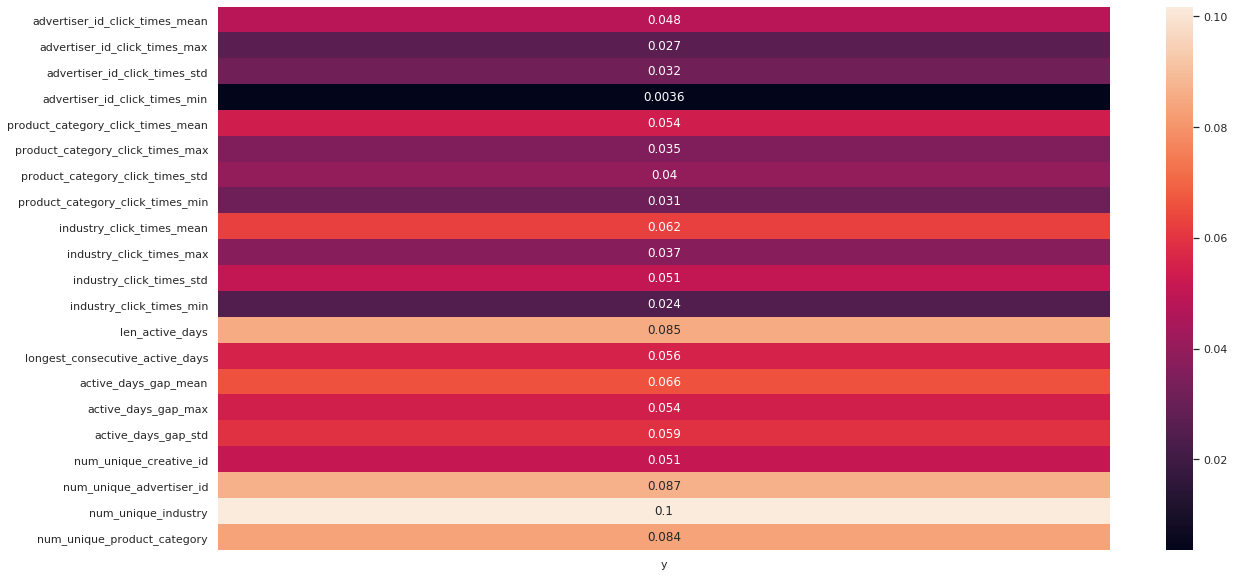

In [36]:
cont_feat_corr_with_label = []
# train_fe_df_model_one = train_fe_df[train_fe_df.model==1]
# train_fe_df.drop(columns=['year','month'],inplace=True)
for cont_col in cont_cols:
    print('%s - %s with corr: %s'% (cont_col, 'y',
        correlation_ratio(train_fe_df['y'],train_fe_df[cont_col])))
    cont_feat_corr_with_label += [correlation_ratio(train_fe_df['y'],train_fe_df[cont_col])]
    
index = cont_cols
cols = ['y']
sns.heatmap(pd.DataFrame(cont_feat_corr_with_label, index=index, columns=cols),annot=True)

advertiser_id_42272 - y with corr: 0.009359255617674665
advertiser_id_33000 - y with corr: 0.07852035452147965
advertiser_id_43805 - y with corr: 0.08610253663161817
advertiser_id_7115 - y with corr: 0.01218979922778361
advertiser_id_10988 - y with corr: 0.015203045398657357
advertiser_id_22123 - y with corr: 0.0026294820895553955
advertiser_id_1132 - y with corr: 0.007817498161120734
advertiser_id_6783 - y with corr: 0.02139966368781235
advertiser_id_19056 - y with corr: 0.0043414003295790685
advertiser_id_40575 - y with corr: 0.004231156066868558
advertiser_id_7026 - y with corr: 0.047845210852282806
advertiser_id_32974 - y with corr: 0.03495247740622015
advertiser_id_885 - y with corr: 0.035561298692164456
advertiser_id_18103 - y with corr: 0.028347595283259624
advertiser_id_17627 - y with corr: 0.03777745958489308
advertiser_id_35549 - y with corr: 0.07058319022680624
advertiser_id_10334 - y with corr: 0.001565136096285831
advertiser_id_2623 - y with corr: 0.052609217427788194
indu

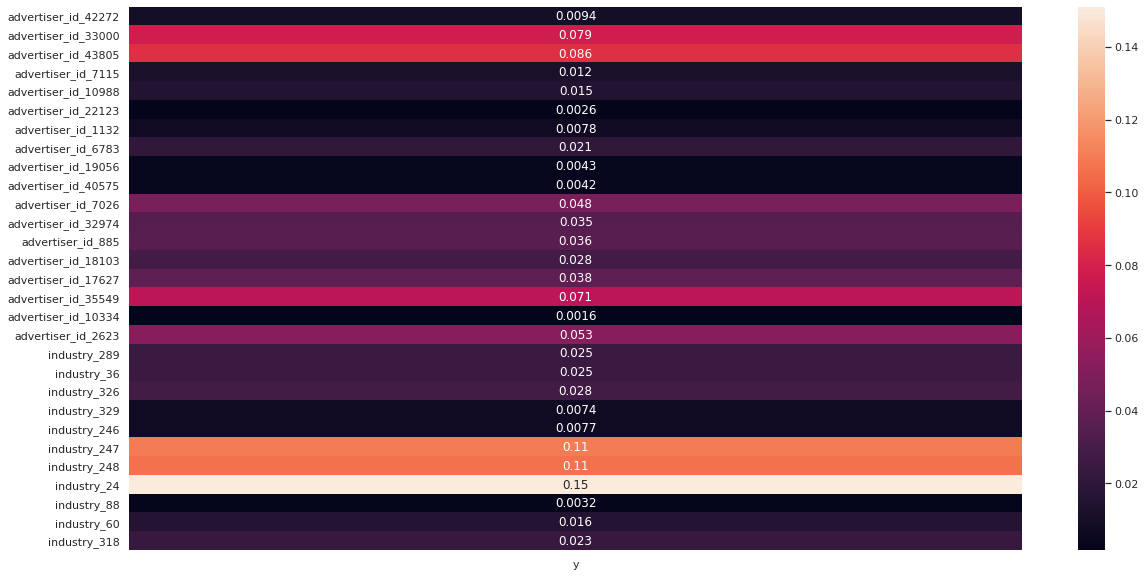

In [37]:
cate_feat_corr_with_label = []
for cate_col in cate_cols:
    print('%s - %s with corr: %s'% (cate_col, 'y',
        theils_u(train_fe_df[cate_col],train_fe_df['y'])))
    cate_feat_corr_with_label += [theils_u(train_fe_df[cate_col], train_fe_df['y'])]

index = cate_cols
cols = ['y']
sns.heatmap(pd.DataFrame(cate_feat_corr_with_label, index=index, columns=cols),annot=True)